In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy
import pandas 
import os

In [3]:
tf.test.is_gpu_available() #check if GPU is available

True

In [0]:
import glob
import matplotlib.pyplot as plt
import cv2

In [5]:
#use nudity library to detect nudity in images

!pip install nudity

drive/My Drive/refugees/00029.jpg


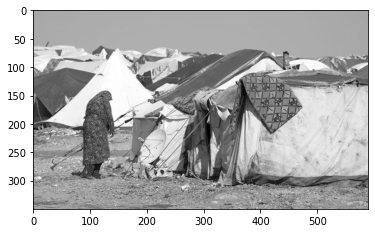

In [6]:
for f in glob.glob('drive/My Drive/refugees/*.jpg'):
    print(f)
    image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    break

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
categories = ["Violence","Normal"]

def make_data_sets(dirname, label, im_size=240):
    
    from tqdm import tqdm
    
    dataset = []
    
    #need to resize, convert to grayscale and add images to dataset array
    
    for file in tqdm(glob.glob(dirname)):
        try:
            image = cv2.imread(file, cv2.IMREAD_COLOR)
#             print("Original Image dim : {}".format(image.shape))
            image = cv2.resize(image, (im_size, im_size))
#             print("Resized Image dim : {}".format(image.shape))        
            
            plt.imshow(image)
            
            dataset.append([image, label])
            
        except Exception as e:
            print('{} occurred, passing'.format(e))
            pass
    
    return dataset

100%|██████████| 100/100 [00:00<00:00, 107.09it/s]


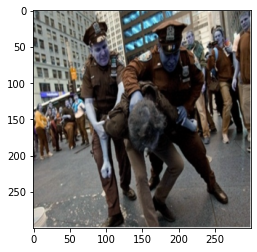

In [9]:
police_data = make_data_sets("drive/My Drive/police_violence/*.jpg", 0, 300)

100%|██████████| 100/100 [00:00<00:00, 108.01it/s]


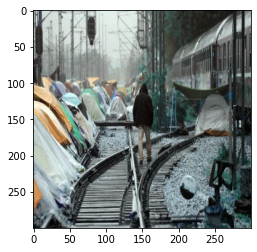

In [10]:
normal_data = make_data_sets('drive/My Drive/refugees/*.jpg', 1, 300)

In [11]:
#check number of images in each of the labels

print(len(police_data))
print(len(normal_data))

100
100


In [0]:
#number of images are low, we have to turn to Transfer Learning.

from tensorflow.keras.applications import vgg19, vgg16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Dropout, Flatten

from tensorflow.keras.utils import normalize

from tensorflow.keras.optimizers import Adam

In [0]:
#create a visual of the model, can be used in report later.

from tensorflow.keras.utils import plot_model

In [14]:
print(police_data[0][0], police_data[0][1])

[[[ 33  31  46]
  [ 33  33  48]
  [ 31  32  47]
  ...
  [ 40  44  59]
  [ 34  44  53]
  [ 24  31  33]]

 [[ 75  74  92]
  [126 129 148]
  [117 126 146]
  ...
  [163 181 201]
  [136 155 166]
  [ 65  72  76]]

 [[ 71  73  94]
  [100 107 131]
  [101 114 138]
  ...
  [145 161 184]
  [128 146 161]
  [ 61  67  74]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [200 200 200]
  [253 253 253]
  [252 252 252]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [244 244 244]
  [250 250 250]
  [254 254 254]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [252 252 252]
  [253 253 253]
  [248 248 248]]] 0


In [15]:
#add both datasets, shuffle them, separate into X and Y

for images in normal_data:
    police_data.append(images)

print(len(police_data)) #should be double of normal data
del normal_data #remove the object, incase you accidentally rerun this cell

from random import shuffle

shuffle(police_data) #shuffle the data

x, y = [], []

for image in police_data:
    x.append(image[0])
    y.append(image[1])

#check if they are all random
print(y[:5])

200
[1, 0, 1, 0, 0]


In [16]:
input_shape = x[0].shape
print("Image Input shape : {}".format(input_shape))

Image Input shape : (300, 300, 3)


In [0]:
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(x,y, test_size=0.15, random_state=42)

In [18]:
#check shapes of your data
print("Train set images : {}".format(len(x_tr)))
print("Train set labels : {}".format(len(y_tr)))
print("Test set images : {}".format(len(x_te)))
print("Test set labels : {}".format(len(y_te)))

Train set images : 170
Train set labels : 170
Test set images : 30
Test set labels : 30


In [0]:
#convert images to numpy arrays, normalize image sets

import numpy as np

x_tr, x_te = np.array(x_tr).astype('float32'), np.array(x_te).astype('float32')

x_tr = x_tr/255.0
x_te = x_te/255.0

In [0]:
from tensorflow.keras.applications.vgg19 import preprocess_input

In [0]:
#extract features using transfer learning. Model = VGG16

orig_input = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(300,300,3))
for layer in orig_input.layers:
    layer.tranable = False

In [32]:
orig_input.outputs

[<tf.Tensor 'block5_pool_1/MaxPool:0' shape=(?, 9, 9, 512) dtype=float32>]

In [33]:
print(orig_input.summary())
plot_model(orig_input, to_file='vgg16.png')

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [0]:
from tensorflow.keras.layers import BatchNormalization

In [37]:
# batch_norm = BatchNormalization()(orig_input.outputs[0])
# drop_l = Dropout(0.3)(batch_norm)
flat_l = Flatten()(orig_input.outputs[0])
dense_l = Dense(256, activation='relu')(flat_l)
# drop_l2 = Dropout(0.3)(dense_l)
output = Dense(1, activation='sigmoid')(dense_l)

model = Model(inputs = orig_input.inputs, outputs = output)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0   

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

ckpt_l = ModelCheckpoint('best_loss_weights.hdf5',
                         monitor = 'val_loss',
                         save_best_only = True,
                         save_weights_only = True)

ckpt_a = ModelCheckpoint('best_acc_weights.hdf5',
                         monitor = 'val_acc',
                         save_best_only = True,
                         save_weights_only = True)

In [0]:
import tensorflow as tf
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(clipnorm=1.0))

In [40]:
model.fit(x_tr, y_tr, validation_split=0.15, epochs = 50, batch_size=8, callbacks=[ckpt_l, ckpt_a], verbose=1)

Train on 144 samples, validate on 26 samples
Epoch 1/50
144/144 [==============================] - 4s 28ms/sample - loss: 2.3911 - acc: 0.4514 - val_loss: 0.5401 - val_acc: 0.7692
Epoch 2/50
144/144 [==============================] - 3s 19ms/sample - loss: 0.7063 - acc: 0.5278 - val_loss: 1.0813 - val_acc: 0.2308
Epoch 3/50
144/144 [==============================] - 3s 19ms/sample - loss: 0.7585 - acc: 0.5417 - val_loss: 0.8856 - val_acc: 0.2308
Epoch 4/50
144/144 [==============================] - 3s 19ms/sample - loss: 0.6975 - acc: 0.5278 - val_loss: 0.7411 - val_acc: 0.2308
Epoch 5/50
144/144 [==============================] - 3s 19ms/sample - loss: 0.6724 - acc: 0.6250 - val_loss: 0.6878 - val_acc: 0.6923
Epoch 6/50
144/144 [==============================] - 3s 20ms/sample - loss: 0.6148 - acc: 0.7361 - val_loss: 0.6792 - val_acc: 0.8077
Epoch 7/50
144/144 [==============================] - 3s 19ms/sample - loss: 0.4829 - acc: 0.7986 - val_loss: 0.8534 - val_acc: 0.5385
Epoch 8/50

In [41]:
#garbage collection
import gc
gc.collect()

14

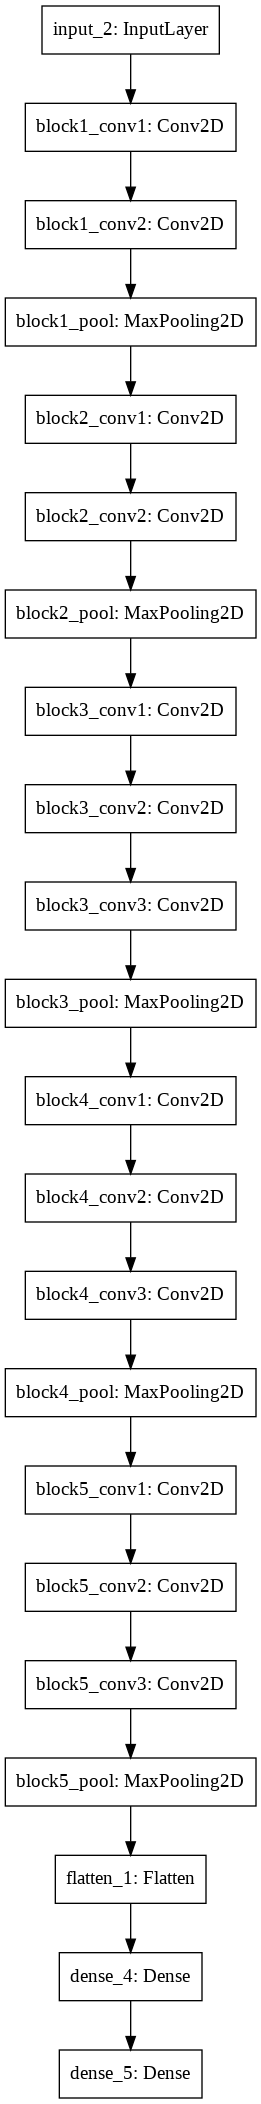

In [42]:
#plot what the model looks like

plot_model(model, to_file='model.png')

In [54]:
#test the model with a sample image file

sample = x_te[0]
print(sample) #image features
print(y_te[0]) #image label

# label = model.predict(sample)

size = 300

#reshape and format image

print(np.array(image[0]).shape)
reshaped_img = np.reshape(image[0], (1, size,size, 3))
print(np.array(reshaped_img).shape)

label = model.predict(reshaped_img)
print("Label : {}".format([label]))

[[[0.7647059  0.6509804  0.5921569 ]
  [0.7607843  0.64705884 0.5882353 ]
  [0.7607843  0.64705884 0.5882353 ]
  ...
  [0.77254903 0.67058825 0.6039216 ]
  [0.77254903 0.67058825 0.6039216 ]
  [0.77254903 0.67058825 0.6039216 ]]

 [[0.7647059  0.6509804  0.5921569 ]
  [0.7607843  0.64705884 0.5882353 ]
  [0.7607843  0.64705884 0.5882353 ]
  ...
  [0.77254903 0.67058825 0.6039216 ]
  [0.77254903 0.67058825 0.6039216 ]
  [0.77254903 0.67058825 0.6039216 ]]

 [[0.7647059  0.6509804  0.5921569 ]
  [0.7607843  0.64705884 0.5882353 ]
  [0.7607843  0.64705884 0.5882353 ]
  ...
  [0.76862746 0.6666667  0.6       ]
  [0.76862746 0.6666667  0.6       ]
  [0.76862746 0.6666667  0.6       ]]

 ...

 [[0.30588236 0.22352941 0.10196079]
  [0.30980393 0.23137255 0.10588235]
  [0.30980393 0.22745098 0.10588235]
  ...
  [0.25490198 0.20784314 0.11764706]
  [0.22745098 0.17254902 0.07843138]
  [0.25882354 0.19607843 0.09019608]]

 [[0.37254903 0.2901961  0.16470589]
  [0.35686275 0.27450982 0.14901961]


In [62]:
model_json = model.to_json() #save the model as a json file

with open('model.json','w') as f:
    f.write(model_json)
print("Model saved to disk.")

Model saved to disk.


In [8]:
#testing pipeline API

def test_image(image, loaded_model='model.json', model_weights='best_acc_weights.hdf5', size=300):

    import numpy as np
    import cv2
    import glob

    from tensorflow.keras.models import load_model
    from tensorflow.keras.models import model_from_json
    from tensorflow.keras.optimizers import Adam

    import matplotlib.pyplot as plt

    from nudity import Nudity
    nudity = Nudity()

    classes = ["Violence","Normal","Nudity"] #our three classes

    copy = image #save a copy of the image
    image = cv2.imread(image, cv2.IMREAD_COLOR) #read image
    image = cv2.resize(image, (size, size)) #resize image to (size x size) to pass to the network

    plt.imshow(image) #show image

    print(image.shape) #3-dim representation

    image = np.reshape(image, (1,size,size,image.shape[2])) #reshape to 4 dim format. 4 dims = [number of samples, height, width, channels]

    print(image.shape) #4-dim representation

    #load model from json file so weights can be put into it

    model_file = open(loaded_model, 'r')
    loaded_model_json = model_file.read()
    model_file.close()

    loaded_model = model_from_json(loaded_model_json) #initialize model
    loaded_model.load_weights(model_weights) #load weights

    loaded_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(clipnorm=1.0)) #same arguments as saved model

    print(loaded_model.summary()) #to check if model has been loaded correctly

    label = 2 #sanity check
    #check nudity
    if nudity.has(copy) == True:
        print("The given image has a {} notion, with label = {}".format(classes[label], label))
        print("Nudity = {}, Probability = {:.2f}%".format(nudity.has(copy), nudity.score(copy)*100))
        return
    
    # print("No nudity detected in image")

    label = loaded_model.predict(image) #predict label of the image

    # print(int(label[0]))
    print("The given image has a {} notion, with label = {}".format(classes[int(label[0])], int(label[0])))

In [5]:
test_image('./00025.jpg')

(300, 300, 3)
(1, 300, 300, 3)
The given image has a Nudity notion, with label = 2
Nudity = True, Probability = 83.13%


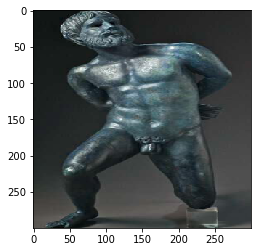

In [9]:
test_image('nudity_image_statue.jpg')